<a href="https://colab.research.google.com/github/yeongcheolkim/DLCafe/blob/feature%2Fpruning/test_env.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch.nn as nn
import torchvision
import torch.utils.data
import torchvision.transforms as transforms
import time
import os
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from os import path
from google.colab import drive
notebooks_dir_name = 'notebooks/'
drive.mount('/content/drive')
notebooks_base_dir = path.join('./MyDrive/test_env/', notebooks_dir_name)

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


transform= transforms.Compose(
    [   transforms.Resize(256),
     transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
     transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223 , 0.24348513, 0.26158784])
    ])

trainset= torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform,
                                      download=True)
testset= torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform,
                                     download=True)


trainloader= torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=8)
testloader= torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=8)





classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

from torch.utils.data import Subset

def train_valid_split(dl, val_split=0.25):
    total_items= dl.dataset.data.shape[0]
    idxs= np.random.permutation(total_items)
    train_idxs, valid_idxs= idxs[round(total_items*val_split):], idxs[:round(total_items*val_split)]
    
    train= Subset(dl, train_idxs)
    valid= Subset(dl, valid_idxs)
    return train, valid


train_dl, valid_dl= train_valid_split(trainloader)


dataiter = iter(trainloader)
images, labels = dataiter.next()



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")




class DSD_Dropout(nn.Module):

    (DENSE, SPARSE) = (0, 1)
    phase = DENSE

    def __init__(self, drop_ratio):
        super(DSD_Dropout, self).__init__()
        self.drop_ratio = drop_ratio

    def forward(self, x):
        if self.phase is DSD_Dropout.DENSE:
            return x
        else:
            k = drop_ratio * x.size()[0]
            kth_value = torch.abs(x).kthvalue(k)[0]
            mask = nn.Threshold(kth_value, 0)
            x = mask(x) + mask(-x)
            return x


class AlexNet(nn.Module):

    def __init__(self,num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            #1
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # 2
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # 3
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            # 4
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            # 5
            nn.Conv2d(384, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            # nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=3, stride=2),

            # nn.Conv2d(64, 192, kernel_size=5, padding=2),
            # nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=3, stride=2),
            
            # nn.Conv2d(192, 384, kernel_size=3, padding=1),
            # nn.ReLU(inplace=True),
            
            # nn.Conv2d(384, 256, kernel_size=3, padding=1),
            # nn.ReLU(inplace=True),
            
            # nn.Conv2d(256, 256, kernel_size=3, padding=1),
            # nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=3, stride=2),
        )

        # substitute the dropout with DSD layer
        self.classifier = nn.Sequential(
            DSD_Dropout(drop_ratio=10),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            DSD_Dropout(drop_ratio=10),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x


# class AlexNet(nn.Module):
#     def __init__(self, num_classes=10):
#         super(AlexNet, self).__init__()
#         #1
#         self.features= nn.Sequential(
#         nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
#         nn.ReLU(inplace=True),
#         nn.MaxPool2d(kernel_size=3, stride=2),
#         #2
#         nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
#         nn.ReLU(inplace=True),
#         nn.MaxPool2d(kernel_size=3, stride=2),
#         #3
#         nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
#         nn.ReLU(inplace=True),
#         #4
#         nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
#         nn.ReLU(inplace=True),
#         #5
#         nn.Conv2d(384, 256, kernel_size=5, stride=1, padding=2),
#         nn.ReLU(inplace=True),
#         nn.MaxPool2d(kernel_size=3, stride=2),
#         )
#         self.avgpool= nn.AvgPool2d(6)
#         self.classifier= nn.Sequential(
#             nn.Dropout(), nn.Linear(256*6*6, 4096), #128*2*2, 1024
#         nn.ReLU(inplace=True), nn.Dropout(),
#         nn.Linear(4096, num_classes))
        
#     def forward(self, x):
#         x= self.features(x)
#         x=x.view(x.size(0), 256*6*6)
#         x= self.classifier(x)
#         return x

model= AlexNet(num_classes=10).to(device)

criterion= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(params= model.parameters(), lr=3e-4)

import datetime

def convert_seconds_format(n):
    return str(datetime.timedelta(seconds =n))

all_losses=[]
all_valid_losses=[]
print('training starting...')
start_time= time.time()


for epoch in range(10):
    epoch_start=time.time()
    model.train()
    running_loss= 0.0
    running_valid_loss=0.0
    predictions=[]
    total=0
    correct=0
   

    for i, data in enumerate(train_dl.dataset, 0):

        inputs, labels= data[0].to(device), data[1].to(device)

        #zero parameter gradients
        optimizer.zero_grad()

        #forward + back optimize
        outputs= model(inputs)
        loss= criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #stats
        running_loss += loss.item()
    all_losses.append(running_loss/i)
    
    #evaluation mode


    model.eval()
    with torch.no_grad():
        for i, data in enumerate(valid_dl.dataset, 0):
            inputs, labels= data[0].to(device), data[1].to(device)
            outputs= model(inputs)
            valid_loss= criterion(outputs, labels)
            running_valid_loss+= valid_loss.item()
            
            #the class with the highest score
            _, predicted= torch.max(outputs.data, 1)
            predictions.append(outputs)
            total+= labels.size(0)
            correct+= (predicted==labels).sum().item()

    epoch_end=time.time()
    epoch_time= convert_seconds_format(epoch_end-epoch_start)
    all_valid_losses.append(valid_loss)
    print(f"epoch {epoch+1}, running loss: {all_losses[-1]}")
    print(f"validation accuracy: {correct/total}. validation loss: {all_valid_losses[-1]}")
    print(f"epoch time: {epoch_time}")


    
torch.save(model.state_dict(),'./test')
end_time= time.time()
train_time= convert_seconds_format(end_time- start_time)
print('training complete')
print(f"total time to train: {train_time}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files already downloaded and verified
Files already downloaded and verified
training starting...
epoch 1, running loss: 1.5260107827095002
validation accuracy: 0.56754. validation loss: 0.8068892359733582
epoch time: 0:03:26.155335
epoch 2, running loss: 0.9824875559605343
validation accuracy: 0.72324. validation loss: 0.5265984535217285
epoch time: 0:03:26.267276
epoch 3, running loss: 0.7525599092893808
validation accuracy: 0.78264. validation loss: 0.3615668714046478
epoch time: 0:03:26.762944
epoch 4, running loss: 0.6168151282241494
validation accuracy: 0.80692. validation loss: 0.46378087997436523
epoch time: 0:03:25.548467
epoch 5, running loss: 0.5254036714722344
validation accuracy: 0.86482. validation loss: 0.3514993488788605
epoch time: 0:03:26.346621
epoch 6, running loss: 0.43886107421943993
validation accuracy: 0.8834. validation loss: 0.5988456

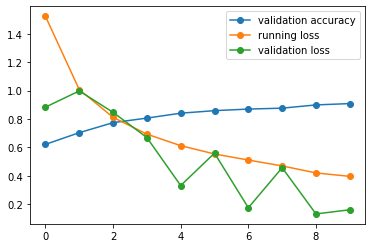

In [ ]:
import pandas as pd
 
df = pd.DataFrame()
df['epoch'] = ['1','2','3','4','5','6','7','8','9','10']

va = [0.62074,
0.70308,
0.77378,
0.80598,
0.84042,
0.8583,
0.86944,
0.87588,
0.89878,
0.90818
]


rl = [1.523522291,
1.007059415,
0.811353376,
0.692758572,
0.611616593,
0.553154545,
0.510278614,
0.468910674,
0.41950782,
0.395380683
]

vl = [0.882915914,
0.997276366,
0.846664667,
0.668697536,
0.330661684,
0.55885905,
0.17408298,
0.456294745,
0.130760387,
0.159974277
]


import matplotlib.pyplot as plt


plt.plot(va,marker='o',label='validation accuracy') ## 선그래프 생성
plt.plot(rl,marker='o',label='running loss') 
plt.plot(vl,marker='o',label='validation loss') 
plt.legend()
plt.show()

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch.nn as nn
import torchvision
import torch.utils.data
import torchvision.transforms as transforms
import time
import os
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from os import path
from google.colab import drive
notebooks_dir_name = 'notebooks/'
drive.mount('/content/drive')
notebooks_base_dir = path.join('./MyDrive/test_env/', notebooks_dir_name)

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


transform= transforms.Compose(
    [   transforms.Resize(256),
     transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
     transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223 , 0.24348513, 0.26158784])
    ])

trainset= torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform,
                                      download=True)
testset= torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform,
                                     download=True)


trainloader= torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=8)
testloader= torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=8)





classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

from torch.utils.data import Subset

def train_valid_split(dl, val_split=0.25):
    total_items= dl.dataset.data.shape[0]
    idxs= np.random.permutation(total_items)
    train_idxs, valid_idxs= idxs[round(total_items*val_split):], idxs[:round(total_items*val_split)]
    
    train= Subset(dl, train_idxs)
    valid= Subset(dl, valid_idxs)
    return train, valid


train_dl, valid_dl= train_valid_split(trainloader)


dataiter = iter(trainloader)
images, labels = dataiter.next()



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")




class DSD_Dropout(nn.Module):

    (DENSE, SPARSE) = (0, 1)
    phase = DENSE

    def __init__(self, drop_ratio):
        super(DSD_Dropout, self).__init__()
        self.drop_ratio = drop_ratio

    def forward(self, x):
        if self.phase is DSD_Dropout.DENSE:
            return x
        else:
            k = self.drop_ratio * x.size()[0]
            kth_value = torch.abs(x).kthvalue(k)[0]
            mask = nn.Threshold(kth_value, 0)
            x = mask(x) + mask(-x)
            return x


class AlexNet(nn.Module):

    def __init__(self,num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            #1
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # 2
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # 3
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            # 4
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            # 5
            nn.Conv2d(384, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            # nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=3, stride=2),

            # nn.Conv2d(64, 192, kernel_size=5, padding=2),
            # nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=3, stride=2),
            
            # nn.Conv2d(192, 384, kernel_size=3, padding=1),
            # nn.ReLU(inplace=True),
            
            # nn.Conv2d(384, 256, kernel_size=3, padding=1),
            # nn.ReLU(inplace=True),
            
            # nn.Conv2d(256, 256, kernel_size=3, padding=1),
            # nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=3, stride=2),
        )

        # substitute the dropout with DSD layer
        self.classifier = nn.Sequential(
            DSD_Dropout(drop_ratio=30),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            DSD_Dropout(drop_ratio=30),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x


# class AlexNet(nn.Module):
#     def __init__(self, num_classes=10):
#         super(AlexNet, self).__init__()
#         #1
#         self.features= nn.Sequential(
#         nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
#         nn.ReLU(inplace=True),
#         nn.MaxPool2d(kernel_size=3, stride=2),
#         #2
#         nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
#         nn.ReLU(inplace=True),
#         nn.MaxPool2d(kernel_size=3, stride=2),
#         #3
#         nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
#         nn.ReLU(inplace=True),
#         #4
#         nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
#         nn.ReLU(inplace=True),
#         #5
#         nn.Conv2d(384, 256, kernel_size=5, stride=1, padding=2),
#         nn.ReLU(inplace=True),
#         nn.MaxPool2d(kernel_size=3, stride=2),
#         )
#         self.avgpool= nn.AvgPool2d(6)
#         self.classifier= nn.Sequential(
#             nn.Dropout(), nn.Linear(256*6*6, 4096), #128*2*2, 1024
#         nn.ReLU(inplace=True), nn.Dropout(),
#         nn.Linear(4096, num_classes))
        
#     def forward(self, x):
#         x= self.features(x)
#         x=x.view(x.size(0), 256*6*6)
#         x= self.classifier(x)
#         return x

model= AlexNet(num_classes=10).to(device)

criterion= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(params= model.parameters(), lr=3e-4)

import datetime

def convert_seconds_format(n):
    return str(datetime.timedelta(seconds =n))

all_losses=[]
all_valid_losses=[]
print('training starting...')
start_time= time.time()


for epoch in range(10):
    epoch_start=time.time()
    model.train()
    running_loss= 0.0
    running_valid_loss=0.0
    predictions=[]
    total=0
    correct=0
   

    for i, data in enumerate(train_dl.dataset, 0):

        inputs, labels= data[0].to(device), data[1].to(device)

        #zero parameter gradients
        optimizer.zero_grad()

        #forward + back optimize
        outputs= model(inputs)
        loss= criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #stats
        running_loss += loss.item()
    all_losses.append(running_loss/i)
    
    #evaluation mode
    
    torch.save(model.state_dict(),'./test')

    model.eval()
    with torch.no_grad():
        for i, data in enumerate(valid_dl.dataset, 0):
            inputs, labels= data[0].to(device), data[1].to(device)
            outputs= model(inputs)
            valid_loss= criterion(outputs, labels)
            running_valid_loss+= valid_loss.item()
            
            #the class with the highest score
            _, predicted= torch.max(outputs.data, 1)
            predictions.append(outputs)
            total+= labels.size(0)
            correct+= (predicted==labels).sum().item()

    epoch_end=time.time()
    epoch_time= convert_seconds_format(epoch_end-epoch_start)
    all_valid_losses.append(valid_loss)
    print(f"epoch {epoch+1}, running loss: {all_losses[-1]}")
    print(f"validation accuracy: {correct/total}. validation loss: {all_valid_losses[-1]}")
    print(f"epoch time: {epoch_time}")



end_time= time.time()
train_time= convert_seconds_format(end_time- start_time)
print('training complete')
print(f"total time to train: {train_time}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files already downloaded and verified
Files already downloaded and verified
training starting...
epoch 1, running loss: 1.5232210527156287
validation accuracy: 0.6088. validation loss: 1.0207276344299316
epoch time: 0:03:36.615360
epoch 2, running loss: 0.976761402073346
validation accuracy: 0.71514. validation loss: 0.7877549529075623
epoch time: 0:03:37.261705
epoch 3, running loss: 0.7561526861370907
validation accuracy: 0.77674. validation loss: 0.5355688333511353
epoch time: 0:03:37.135463
epoch 4, running loss: 0.6117630687550607
validation accuracy: 0.82538. validation loss: 0.7390695214271545
epoch time: 0:03:38.013145
epoch 5, running loss: 0.518382025684651
validation accuracy: 0.81402. validation loss: 0.5042576193809509
epoch time: 0:03:37.326299
epoch 6, running loss: 0.4363732442030833
validation accuracy: 0.87778. validation loss: 0.28856578469

In [6]:
!git clone 'https://github.com/yeongcheolkim/DLCafe' '/gdrive/My Drive/test_env'





fatal: destination path '/gdrive/My Drive/test_env' already exists and is not an empty directory.
